Imports

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np
import helpers.evaluate
from helpers.model_list import model_map
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import warnings
from sklearn.exceptions import FitFailedWarning

#Import models
models = {name: model_class() for name, model_class in model_map.items()}

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in Data

In [2]:
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
X = df.drop(columns=["Diabetes_binary"])
feature_names = X.columns
y = df["Diabetes_binary"]
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [ ]:
# Univariate Analysis
plt.figure()
df['BMI'].hist(bins=20)
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.show()

# 13-level age category 1 = 18-24 9 = 60-64 13 = 80 or older
plt.figure()
df['Age'].hist(bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Identify categorical/binary features to visualize their distributions.

categorical_features = [
    'Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck',
    'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity',
    'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
    'NoDocbcCost', 'Sex'
]

for col in categorical_features:
    plt.figure()
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [ ]:
# Mulitvariate analysis

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, fignum=1)
plt.title("Correlation Matrix", pad=20)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.show()

In [ ]:
# 2. Scatter Plot: BMI vs Age 
plt.figure()
plt.scatter(df['BMI'], df['Age'], alpha=0.6)
plt.title("Scatter Plot: BMI vs Age")
plt.xlabel("BMI")
plt.ylabel("Age")
plt.show()

In [ ]:
diabetes_df=df[(df['Diabetes_binary']==1)]

for col in categorical_features:
    if(col!='Diabetes_binary'):
        plt.figure()
        diabetes_df[col].value_counts().plot(kind='bar')
        plt.title(f"Distribution of {col} with diabetes")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

Explore Data

In [ ]:
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)


In [ ]:
print("\nSummary statistics:")
print(df.describe())

In [ ]:
# Count missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())

In [ ]:
# Check for duplicate records
print("\nNumber of duplicate rows:", df.duplicated().sum())

Clean Data

In [3]:
print("Dataset shape:", df.shape)
df = df.drop_duplicates()
print("New shape:", df.shape)

Dataset shape: (70692, 22)
New shape: (69057, 22)


Split Data

In [4]:
#Transform target
le = LabelEncoder()
y = le.fit_transform(y)

#Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

#Scale Data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Reassign col names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)


Feature Selection

In [ ]:
#Feature Selection:
#Using RFE on each type of model to select for optimal model features
#saved as results[name][n] = (accuracy, selected_features[]), and results[name] =  {n, best features}
#takes abt 10 mins
model_feature_accuracy = {}
for name, model in models.items():
    print(f"\n--- Selecting Features for {name} ---")
    #necessary to fit to get feature importances
    model.train(X_train_scaled, y_train)
    for n in range(X.shape[1], 0, -1):
        print("Computing for ", n, " features")
        if hasattr(model.model, 'coef_') or hasattr(model.model, 'feature_importances_'):
            selection = RFE(model.model, n_features_to_select=n, importance_getter='auto')
        else:
            #I tried doing some type of permutation importance for models that don't have built in importances, but it didn't work
            continue
        
        selection.fit(X_train_scaled, y_train)
        pred = selection.predict(X_test_scaled)
        acc = accuracy_score(y_test, pred)
        if(name not in model_feature_accuracy):
            model_feature_accuracy[name] = {}
        model_feature_accuracy[name][n] = (acc, feature_names[selection.support_])

In [ ]:
#Showing accuracy as graph
plt.figure(figsize=(10, 6))


# Loop through the models in the results dictionary
for model_name, accuracies in model_feature_accuracy.items():
    n = list(accuracies.keys())
    accuracies = [accuracy for accuracy, _ in accuracies.values()]
    
    # Plot the accuracy against n features for each model
    plt.plot(n, accuracies, label=model_name, marker='o')

plt.xlabel('Number of Features (n)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Number of Features')
plt.legend(title="Model Names")
plt.grid(True)
plt.xlim(21, 1)
plt.xticks(range(21, 1, -2))
# Show the plot
plt.show()

HyperParameter Tuning

In [ ]:
#ignoring warnings when tuning hyperparams
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
#WARNING - Running this code takes an hour or more. No need to run it again, since tuning_results.db already exists with the generated results.
for name, model in models.items():
        print(f"\n--- Tuning Hyperparameters for {name} ---")
        model.reset(name)
        #if there's not feature selection done on the model
        if(name not in model_feature_accuracy):
            X_tuning_scaled = scaler.fit_transform(X)
            model.tune_params(X_tuning_scaled, y, 25, name)
        else:
            max_acc = 0
            features = []
            #if we have feature selection on the model, get the highest accuracy
            for n, data in model_feature_accuracy[name].items():
                if(data[0] > max_acc):
                    max_acc = data[0]
                    features = data[1]
            #now that we have the feature list, seperate the training and testing features
            X_tuning = X[features]
            X_tuning_scaled = scaler.fit_transform(X_tuning)
            model.tune_params(X_tuning_scaled, y, 25, name)


Train Models

In [ ]:


total_metrics = {}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")
    model.train(X_train_scaled, y_train)
    
    predictions = model.predict(X_test_scaled)
    
    metrics = helpers.evaluate.evaluate_model(y_test, predictions, name)
    total_metrics[name] = metrics


Report Stats

In [ ]:
# Get best metrics
bestModel = ""
bestPerformance = 0.0
for name, metrics in total_metrics.items():
    if metrics["Accuracy"] > bestPerformance:
        bestModel = name
        bestPerformance = metrics["Accuracy"]

print("Best Model =", bestModel)
print("Model Accuracy =", bestPerformance)


Train with feature selection and hyperparameters


--- Training with Feature Selection and Hyperparams for Decision Tree ---
Decision Tree Performance:
Accuracy:  0.7193
Precision: 0.7198
Recall:    0.7193
F1 Score:  0.7191
Confusion Matrix:
[[19627  8657]
 [ 7220 21050]]


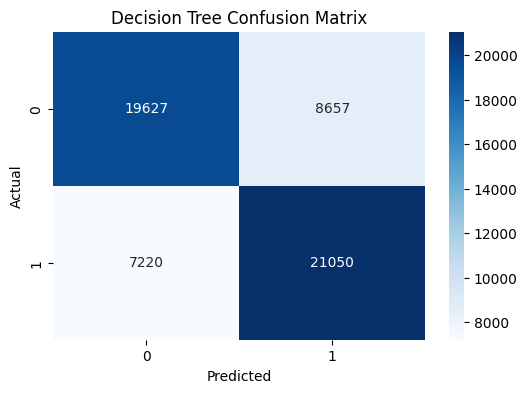


--- Training with Feature Selection and Hyperparams for Logistic Regression ---
Logistic Regression Performance:
Accuracy:  0.7480
Precision: 0.7486
Recall:    0.7480
F1 Score:  0.7479
Confusion Matrix:
[[20482  7802]
 [ 6447 21823]]


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


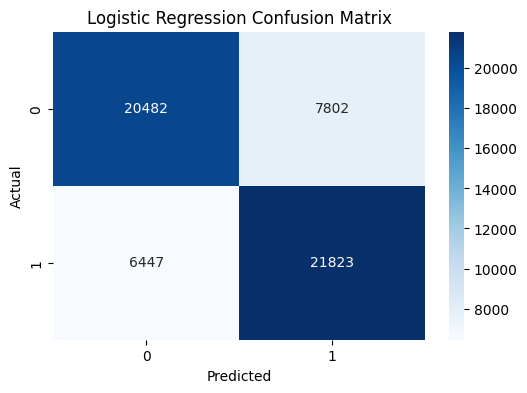


--- Training with Feature Selection and Hyperparams for K Nearest Neighbors ---
K Nearest Neighbors Performance:
Accuracy:  0.7186
Precision: 0.7202
Recall:    0.7186
F1 Score:  0.7181
Confusion Matrix:
[[19125  9159]
 [ 6753 21517]]


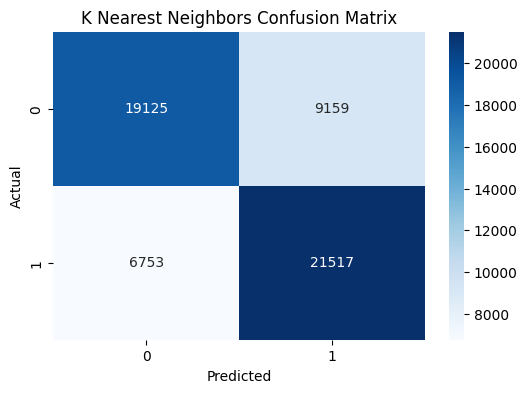


--- Training with Feature Selection and Hyperparams for SVC ---
SVC Performance:
Accuracy:  0.7406
Precision: 0.7420
Recall:    0.7406
F1 Score:  0.7402
Confusion Matrix:
[[19865  8419]
 [ 6251 22019]]


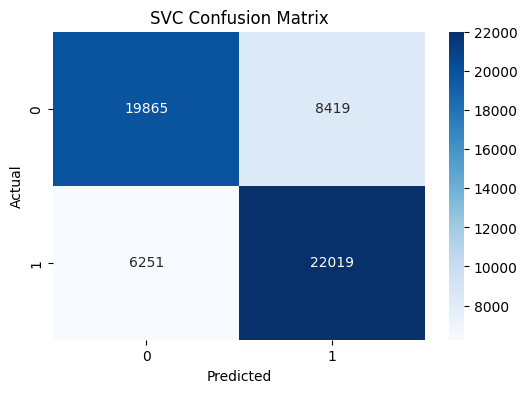


--- Training with Feature Selection and Hyperparams for AdaBoost ---
AdaBoost Performance:
Accuracy:  0.7265
Precision: 0.7267
Recall:    0.7265
F1 Score:  0.7264
Confusion Matrix:
[[20153  8131]
 [ 7337 20933]]


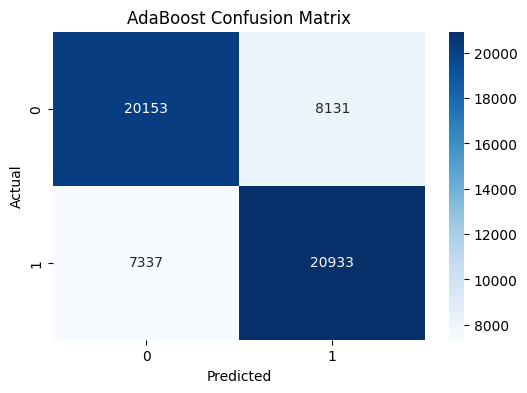


--- Training with Feature Selection and Hyperparams for Bagging ---
Bagging Performance:
Accuracy:  0.7250
Precision: 0.7257
Recall:    0.7250
F1 Score:  0.7247
Confusion Matrix:
[[19714  8570]
 [ 6985 21285]]


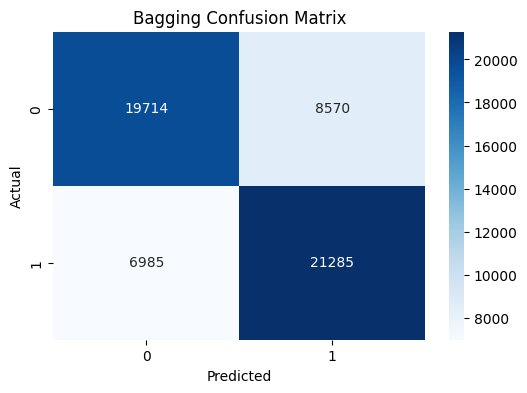


--- Training with Feature Selection and Hyperparams for Gradient Boosting ---
Gradient Boosting Performance:
Accuracy:  0.7067
Precision: 0.7070
Recall:    0.7067
F1 Score:  0.7066
Confusion Matrix:
[[19439  8845]
 [ 7743 20527]]


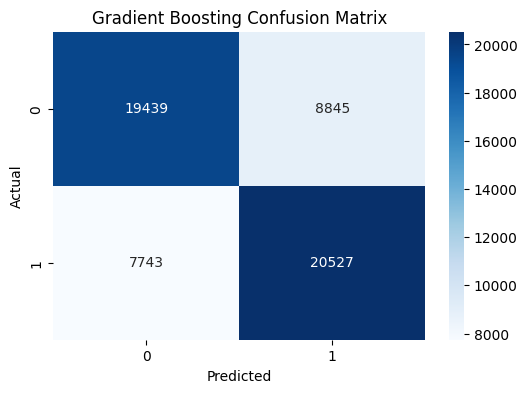


--- Training with Feature Selection and Hyperparams for Random Forest ---
Random Forest Performance:
Accuracy:  0.7502
Precision: 0.7527
Recall:    0.7502
F1 Score:  0.7495
Confusion Matrix:
[[19812  8472]
 [ 5658 22612]]


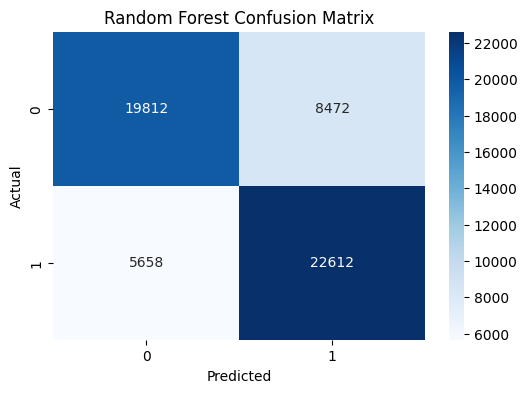


--- Training with Feature Selection and Hyperparams for Stacking ---


In [ ]:
total_metrics2 = {}
for name, model in models.items():
    print(f"\n--- Training with Feature Selection and Hyperparams for {name} ---")
    if(name=="Stacking"):
        continue
    
    #loading in params
    model.load_params(name)
    #if there's no feature selection data for model
    if(name not in model_feature_accuracy):
            model.train(X_train_scaled, y_train)
            predictions = model.predict(X_test_scaled)
            metrics = helpers.evaluate.evaluate_model(y_test, predictions, name)
            total_metrics2[name] = metrics
    else:
        max_acc = 0
        features = []
        #if we have feature selection on the model, get the highest accuracy
        for n, data in model_feature_accuracy[name].items():
            if(data[0] > max_acc):
                max_acc = data[0]
                features = data[1]
        #now that we have the feature list, seperate the training and testing features
        X_tuning = X[features]
        
        #Split Data
        X_train_feature_selected, X_test_feature_selected, y_train_feature_selected, y_test_feature_selected = train_test_split(X_tuning, y, test_size=0.8)

        #Scale Data
        scaler = MinMaxScaler()
        X_train_feature_scaled = scaler.fit_transform(X_train_feature_selected)
        X_test_feature_scaled = scaler.transform(X_test_feature_selected)

        #Reassign col names
        X_train_scaled = pd.DataFrame(X_train_feature_scaled, columns=X.columns)
        X_test_scaled = pd.DataFrame(X_test_feature_scaled, columns=X.columns)

        model.train(X_train_feature_scaled, y_train_feature_selected)
        
        predictions = model.predict(X_test_feature_scaled)
        
        metrics = helpers.evaluate.evaluate_model(y_test_feature_selected, predictions, name)
        total_metrics2[name] = metrics

Metric Report 2

In [ ]:
# Get best metrics
bestModel = ""
bestPerformance = 0.0
for name, metrics in total_metrics.items():
    if metrics["Accuracy"] > bestPerformance:
        bestModel = name
        bestPerformance = metrics["Accuracy"]

print("Best Model =", bestModel)
print("Model Accuracy =", bestPerformance)